In [1]:
# Packages

import os
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import re
from itertools import compress
import ast
import networkx as nx

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

#data_path = os.path.join('C:/', 'data', 'horesta')
data_path = os.path.join('D:/', 'data', 'horesta')
out_path = os.path.join('..', 'output')

In [2]:
# Loading data
path = os.path.join(data_path, 'horesta_posts_2021-03-25.json')

with open(path, 'r') as file:
    data = json.load(file)
    
len(data)

1351

In [3]:
# Converting data to data frame

df = pd.DataFrame.from_records(data)

df.head()

,url,accessed,title,tags,links,publish_date,access_date,text,html
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",[],04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\..."
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",[],04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\..."
2,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",[],03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\..."
3,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...","[/webinar-med-danske-bank, /cdn-cgi/l/email-pr...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\..."
4,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",[/events/2020/december/webinar-med-vaekstfonde...,02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\..."


In [9]:
# Adding date variables

df['publish_date'] = pd.to_datetime(df['publish_date'], format = '%d-%m - %Y')
df['post_month'] = df['publish_date'].dt.month
df['post_year'] = df['publish_date'].dt.year
df['year_month'] = df['publish_date'].apply(lambda x: str(x)[0:7])
df = df.sort_values('publish_date')

In [280]:
# Functions

nlp = spacy.load("da_core_news_sm", disable=["ner"])

stop_words = list(nlp.Defaults.stop_words)
                                            
def tokenizer_custom(text, stop_words=stop_words, tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    text = text.replace('\n', ' ')
    numbers_re = r".*\d.*"
    punct_regex = r"[^\w\s]"
    
    doc = nlp(text)
        
    pos_tags = tags # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for word in doc:
        if word.pos_ in pos_tags and len(word.lemma_) > 1 and word.lemma_.lower() not in stop_words and not re.match(numbers_re, word.lemma_.lower()):
            token = word.lemma_.lower() # Returning the word in lower-case.
            token = re.sub(punct_regex, "", token)
            tokens.append(token)

    return(tokens)


def create_tfidfdtm(df, tokensvar = 'tokens'):

    def return_tokens(tokens):
        return tokens

    text_tokens = df['tokens']

    vectorizer = TfidfVectorizer(
        tokenizer=return_tokens,
        preprocessor=return_tokens,
        token_pattern=None,
        min_df = 5,
        max_df = 0.9
        )

    transformed_documents = vectorizer.fit_transform(text_tokens)

    transformed_documents_as_array = transformed_documents.toarray()
    tfidf_dtm = pd.DataFrame(transformed_documents_as_array, columns = vectorizer.get_feature_names())
    
    return(tfidf_dtm)


def create_phaseset(df, start_date, end_date, datevar = 'publish_date', stop_words=stop_words, tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    subset = df.loc[(df[datevar] >= start_date) & (df[datevar] <= end_date), :].reset_index()
    subset['text_id'] = pd.Series(subset.index).apply(lambda i: "text_" + str(i))
    
    subset['tokens'] = subset['text'].apply(tokenizer_custom, tags = tags)
    
    tfidf_dtm = create_tfidfdtm(subset)
    
    tfidf_tidy = tfidf_dtm.melt(var_name='token', value_name = 'tf-idf', ignore_index = False)
    tfidf_tidy['text_id'] = pd.Series(tfidf_tidy.index).apply(lambda i: "text_" + str(i))
    
    subset_tidy = subset.explode('tokens').rename(columns = {'tokens': 'token'})
    
    subset_tidy_unique = subset_tidy.drop_duplicates(subset = ['url', 'title', 'publish_date', 'token'])
    
    subset_tfidf = pd.merge(subset_tidy_unique, tfidf_tidy, how = "left", on = ["text_id", "token"])
    
    subset_tfidf = pd.merge(subset_tfidf, subset.loc[:, ['index', 'tokens']], how = "left", on = 'index')
    
    return(subset_tfidf)


def get_top50(df):
    
    top50 = df.groupby('token')['tf-idf'].sum().sort_values(ascending = False)[0:50]
    
    return(top50)

In [323]:
# network

from collections import Counter
from itertools import compress
from itertools import combinations

def get_coocedges_count(df, keywords, min_count = 2, tfidf_thres = 0.1):

    keywords = keywords

    phase1_nw = phase1.loc[phase1['token'].isin(keywords), :]
    phase1_nw = phase1_nw.drop_duplicates(subset = 'index')

    tokens_list = phase1_nw['tokens']
    sig_tokens = list(phase1.loc[phase1['tf-idf'] >= tfidf_thres, 'token'].unique())

    comb_list = []
    for tokens in tokens_list:
        tokens = [word for word in tokens if word not in keywords and word in sig_tokens]
        comb_list = comb_list + list(combinations(tokens, 2))

    comb_counts = list(Counter(comb_list).items())

    edge_tuples = list()

    for comb_count in comb_counts:
        edge_tuple = tuple([comb_count[0][0], comb_count[0][1], comb_count[1]])
        edge_tuples.append(edge_tuple)

    edges_filtered = [edge_tuple for edge_tuple in edge_tuples if edge_tuple[2] >= min_count]
    
    return(edges_filtered)

def get_coocedges(df, keywords):

    keywords = keywords

    phase1_nw = phase1.loc[phase1['token'].isin(keywords), :]
    phase1_nw = phase1_nw.drop_duplicates(subset = 'index')

    tokens_list = phase1_nw['tokens']

    comb_list = []
    for tokens in tokens_list:
        comb_list = comb_list + list(combinations(tokens, 2))
    
    return(comb_list)

def draw_coocnw(df, keywords, min_count = 2, tfidf_thres = 0.1):
    edges = get_coocedges_count(df = df, keywords = keywords, min_count = min_count, tfidf_thres = tfidf_thres)
    
    G = nx.Graph()
    G.add_weighted_edges_from(edges)

    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()

    fig = plt.figure(figsize=(24,24))

    pos = nx.nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nodelist,
                           node_size=1500,
                           node_color='grey',
                           alpha=0.7)
    nx.draw_networkx_edges(G,pos,
                           edgelist = widths.keys(),
                           width=[width / 2 for width in list(widths.values())],
                           edge_color='lightblue',
                           alpha=0.6)
    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='black')

    plt.box(False)
    plt.title("CO-OCCURENCES FOR {}".format(', '.join(keywords)))
    plt.show()
    return(fig)

In [309]:
phase1_start = datetime(2019,12,1,0,0)
phase1_end = datetime(2020,3,12,0,0)

tags = ['NOUN', 'ADJ']

phase1 = create_phaseset(df, start_date = phase1_start, end_date = phase1_end, tags = tags)

In [310]:
get_top50(phase1)

token
virksomhed       14.095566
erhverv           7.480062
hotel             7.174641
år                7.123384
stor              6.787522
medarbejder       6.562311
protected         5.579013
email             5.479538
dansk             5.401596
mangen            5.384994
direktør          5.371228
information       5.028561
yderlig           5.028323
pct               5.013817
kontakt           4.948251
restaurant        4.904312
branche           4.808765
bæredygtig        4.713749
mulighed          4.606666
regering          4.492357
kr                4.482734
gæst              4.341652
tlf               4.318758
del               4.069978
medlem            3.962996
marts             3.947955
måned             3.891403
dag               3.842183
hele              3.754610
møde              3.738845
arbejde           3.718148
bæredygtighed     3.656087
afgift            3.637896
horesta           3.594043
kl                3.592715
grøn              3.552372
fødevarechef      3.51

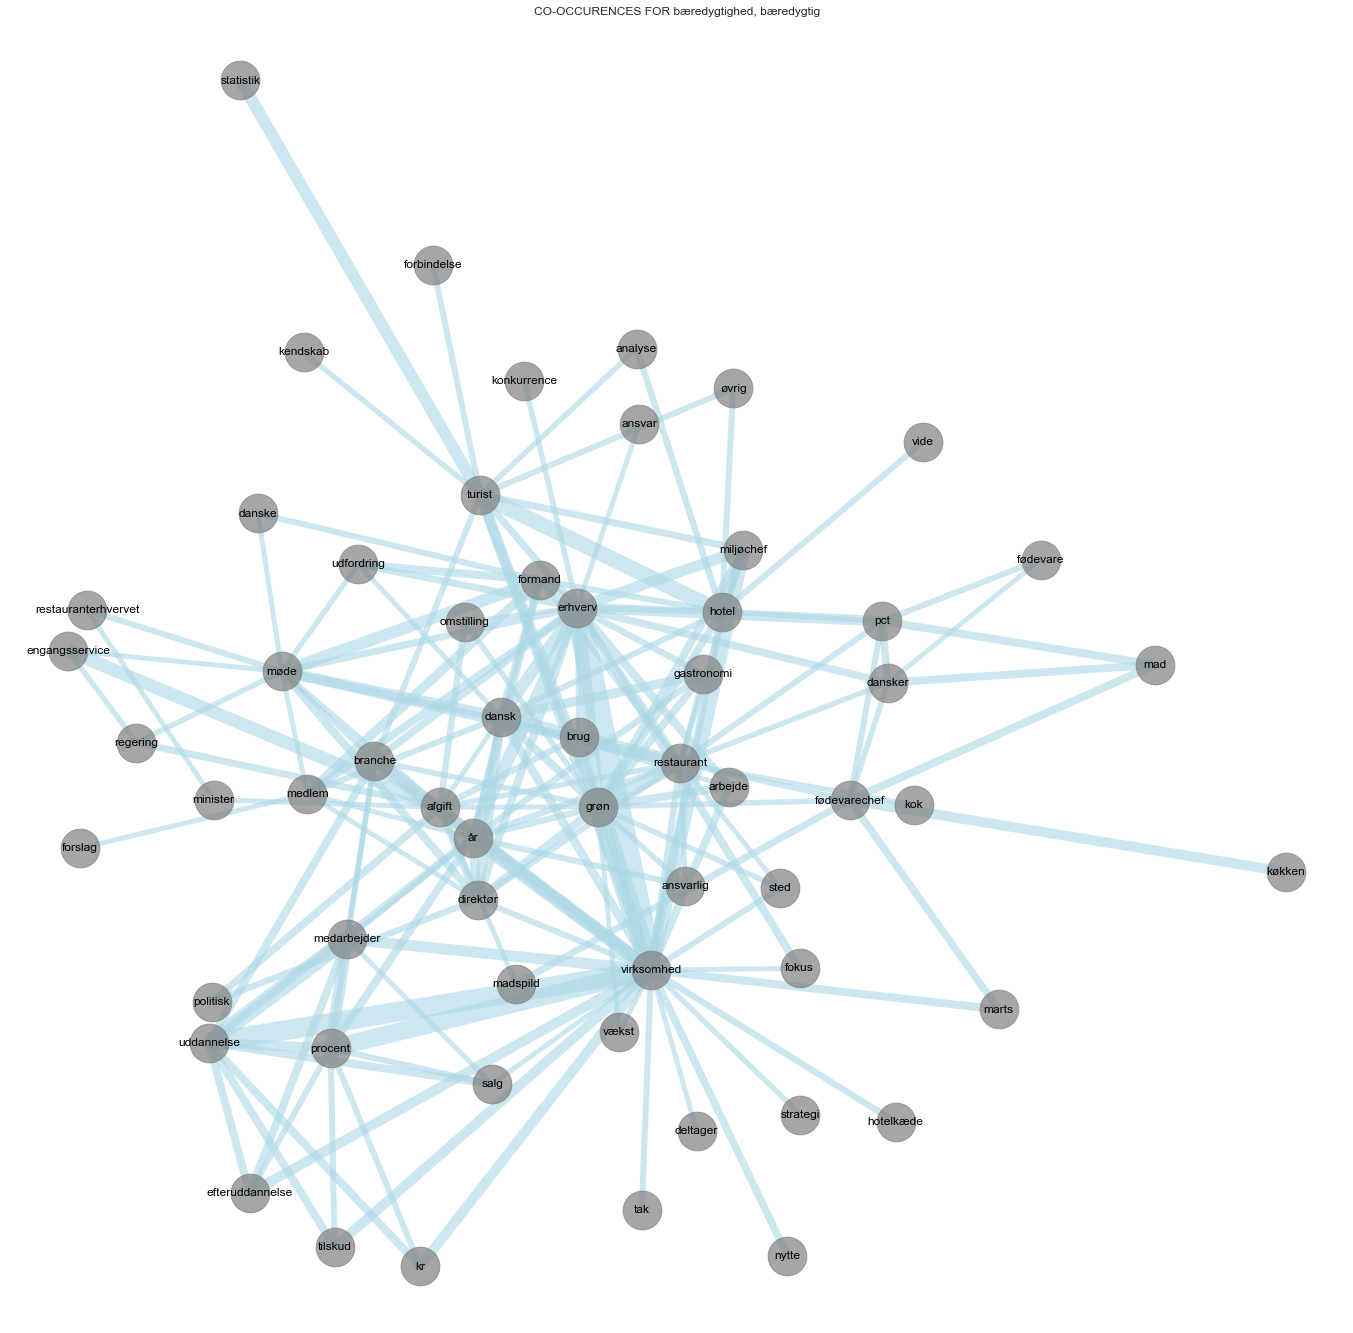

In [324]:
keywords = ['bæredygtighed', 'bæredygtig']

plot = draw_coocnw(phase1, keywords, min_count = 10, tfidf_thres = 0.3)
plot.savefig('nw')